In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch.nn as nn
import torch
import idx2numpy 
from torchvision.transforms.functional import gaussian_blur
from torch import optim

from matplotlib import pyplot as plt
from deepshape.surfaces import * 

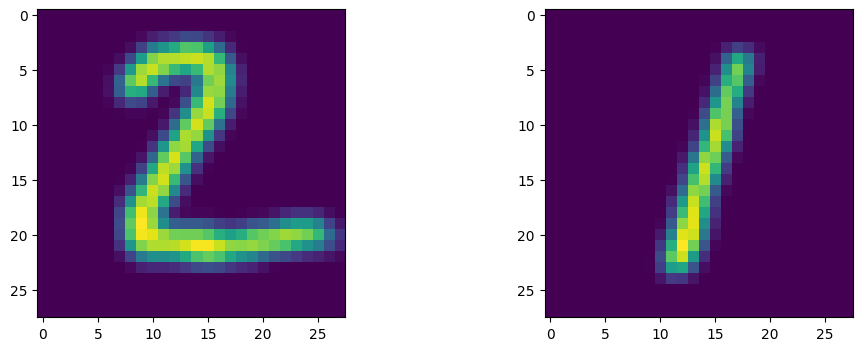

In [3]:
imgfile = "../data/t10k-images.idx3-ubyte"
imgdata = torch.tensor( idx2numpy.convert_from_file(imgfile), dtype=torch.float )
labelfile = "../data/t10k-labels.idx1-ubyte"
labels = torch.tensor( idx2numpy.convert_from_file(labelfile))
imgdata = gaussian_blur(imgdata, [3, 3]) / 255.

img1 = imgdata[1]
img2 = imgdata[2]

fig, (ax1, ax2 )= plt.subplots(1, 2)
ax1.imshow(img1)
ax2.imshow(img2)
plt.show()

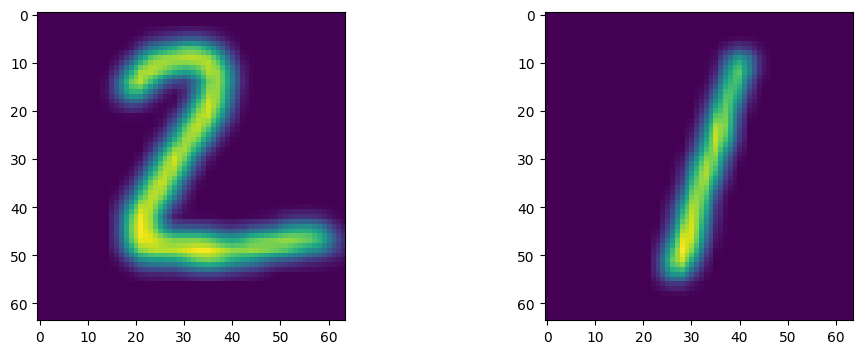

In [4]:
k = 64
f = SingleChannelImageSurface(img1)
g = SingleChannelImageSurface(img2)


XX = torch_square_grid(k=k)
X = XX.view(-1, 2)
Zf = f(XX).permute(2, 0, 1).numpy()
Zg = g(XX).permute(2, 0, 1).numpy()

fig, (ax1, ax2 )= plt.subplots(1, 2)
ax1.imshow(Zf[2])
ax2.imshow(Zg[2])
plt.show()

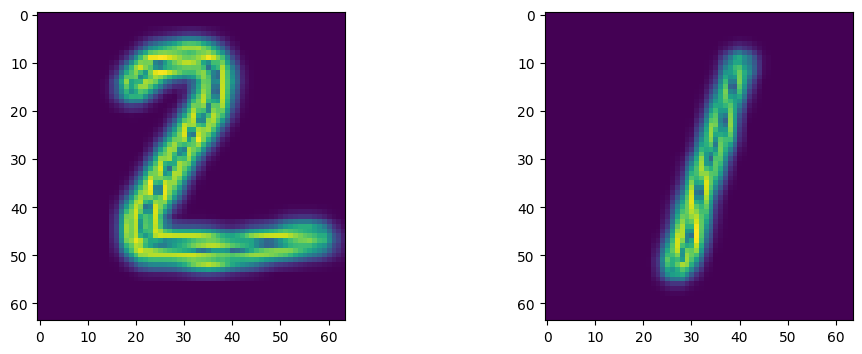

In [5]:
q = Qmap(f)
r = Qmap(g)
Zq = q(XX).permute(2, 0, 1).numpy()
Zr = r(XX).permute(2, 0, 1).numpy()

fig, (ax1, ax2 )= plt.subplots(1, 2)
ax1.imshow(Zq[2])
ax2.imshow(Zr[2])
plt.show()

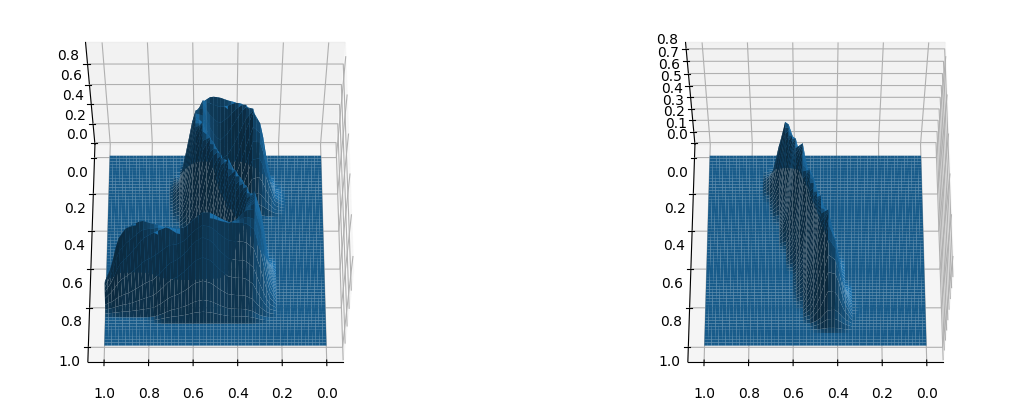

In [6]:
%matplotlib inline
# Init Figure 
fig = plt.figure(figsize=(12, 4))
ax = plt.axes((0., 1., 0.5, 1.), projection='3d')
ax.plot_surface(*Zf, rstride=1, cstride=1)
ax.view_init(+60, -270)
ax = plt.axes((0.5, 1., 0.5, 1.), projection='3d')
ax.plot_surface(*Zg, rstride=1, cstride=1)
ax.view_init(+60, -270)
plt.show(fig)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define reparametrization-network
RN = ReparametrizationNetwork(nn.ModuleList(
    [PalaisLayer(3) for _ in range(20)]
)).to(device)

loss_func = SingleComponentLoss(q, r, k=32).to(device)

# Define optimizer and learning rate scheduler
optimizer = optim.LBFGS(RN.parameters(), lr=1.0, max_iter=100, line_search_fn="strong_wolfe")
# optimizer = optim.Adam(RN.parameters(), lr=1e-3)

# Train and store convergence
errors = reparametrize(q, r, RN, loss_func, optimizer, 200, Logger(5))#, scheduler=scheduler)

RN.to("cpu"), loss_func.to("cpu");

[Iter     1] loss: 0.530894
[Iter     6] loss: 0.387612
[Iter    11] loss: 0.353609
[Iter    16] loss: 0.352225
[Iter    21] loss: 0.346981
[Iter    26] loss: 0.325674
[Iter    31] loss: 0.315661
[Iter    36] loss: 0.310722
[Iter    41] loss: 0.306571
[Iter    46] loss: 0.298810
[Iter    51] loss: 0.615541
[Iter    56] loss: 0.292186
[Iter    61] loss: 0.278648
[Iter    66] loss: 0.276269
[Iter    71] loss: 0.250976
[Iter    76] loss: 0.250371
[Iter    81] loss: 0.244556
[Iter    86] loss: 0.240136
[Iter    91] loss: 0.237975
[Iter    96] loss: 0.234433
[Iter   101] loss: 0.229920
[Iter   106] loss: 0.235432
[Iter   111] loss: 0.227452
[Iter   116] loss: 0.222506
[Iter   121] loss: 0.219823
[Iter   126] loss: 0.214812
[Iter   126] loss: 0.214812

Finished training in 33.41315s


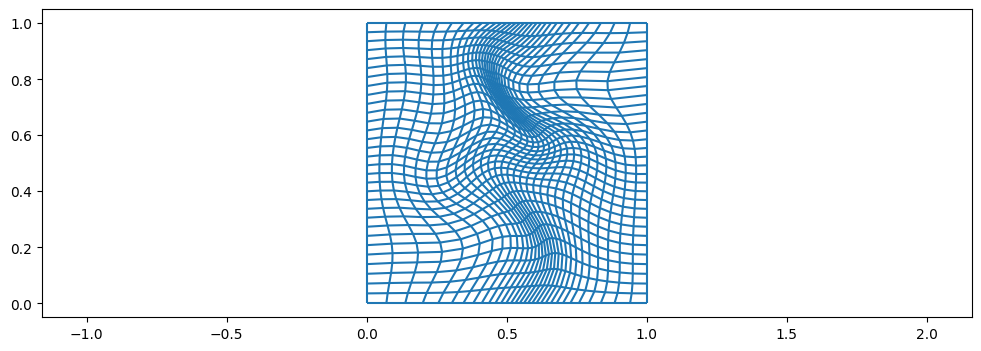

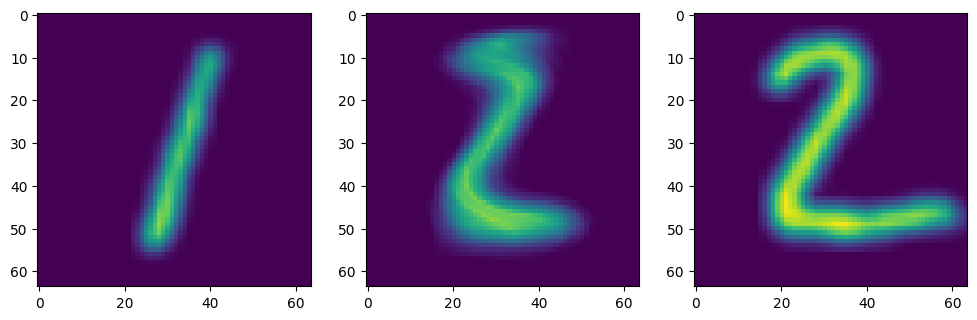

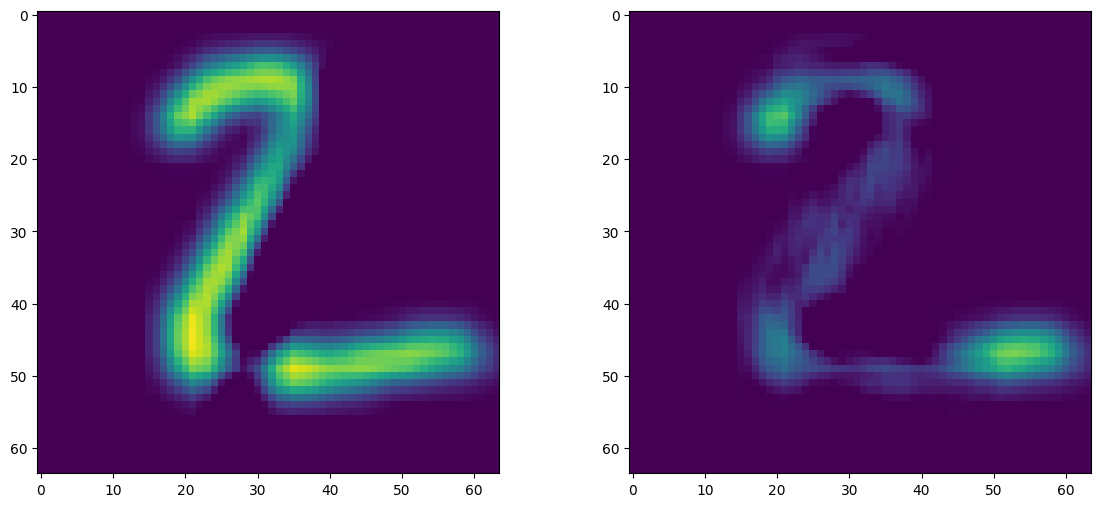

In [8]:
u = lambda x: RN(x)
plot_diffeomorphism(u, k=32)
plt.axis("equal")

fphi = f.compose(u)
gphi = g.compose(u)

Zff = fphi(X).view(k, k, 3).detach().numpy()
Zgg = gphi(X).view(k, k, 3).detach().numpy()

fig, (ax1, ax2 , ax3)= plt.subplots(1, 3)
ax3.imshow(Zf[2], vmin=0., vmax=1.)
ax2.imshow(Zgg[..., 2], vmin=0., vmax=1.)
# plot_diffeomorphism(k=32, ax=ax2)
ax1.imshow(Zg[2],  vmin=0., vmax=1.)
plt.show()

fig, (ax1, ax3,)= plt.subplots(1, 2, figsize=(14, 6))
ax1.imshow(Zf[2] - Zg[2], vmin=0., vmax=1.)
# plot_diffeomorphism(u, k=32, ax=ax2)
ax3.imshow(Zf[2] - Zgg[..., 2], vmin=0., vmax=1.)
plt.show()

### Distance Matrix Compute

def fit(q, r, RN, X, iters, optimizer_constructor, epsilon, delta, verbose=1):
    for i in range(iters):
        optimizer.zero_grad()
        Y, U = RN(X)
        Q = q(X)
        R = torch.sqrt(U) * r(Y)

        # Compute loss, and perform a backward pass and gradient step
#         l = single_component_mse(Q, R, 2)
        l = torch.nn.functional.mse_loss(Q, R)

        l.backward()
        optimizer.step()

        with torch.no_grad():
            Y = X
            for layer in RN.layers:
                layer.project(Y, epsilon, delta)
                Y, _ = layer(Y)

        if i % 10 == 0 and verbose >= 2:
            print(f"{i:5d} - loss: {l:>.10f}")
            
    if verbose >= 1:
        print(f"Final loss: {l:>.10f}")

    return l.item()


def fit_warp_distance(q, r, RN, X, iters, optimizer_constructor, epsilon, delta, verbose=1):
    for i in range(iters):
        optimizer.zero_grad()
        Y, U = RN(X)
        Q = q(X)
        R = torch.sqrt(U) * r(Y)

        # Compute loss, and perform a backward pass and gradient step
        l = single_component_mse(Q, R, 2)

        l.backward()
        optimizer.step()

        with torch.no_grad():
            Y = X
            for layer in RN.layers:
                layer.project(Y, epsilon, delta)
                Y, _ = layer(Y)

        if i % 10 == 0 and verbose >= 2:m
            print(f"{i:5d} - loss: {l:>.10f}")
            
    if verbose >= 1:
        print(f"Final loss: {l:>.10f}")

    return torch.nn.functional.mse_loss(Y)

In [4]:
examples_per_digit = 2
digits = torch.empty(10 *  examples_per_digit, 28, 28)
sublabels = torch.empty(10 * examples_per_digit, dtype=int)

for i in range(10):
    start = i * examples_per_digit
    digits[start:start+examples_per_digit] = imgdata[labels == i][:examples_per_digit]
    sublabels[start:start+examples_per_digit] = i
    



In [5]:
optim_builder = optimizer_builder(torch.optim.LBFGS, lr=0.9, max_iter=50)

# Total number of images
num_images = digits.shape[0]

# Create empty distance matrix
distance_matrix = np.zeros((num_images, num_images))

for i in range(digits.shape[0]):

    print(f"{'=' * 30 } Digit {sublabels[i]} {'=' * 30}")
    
    # Create qmap for current image
    f = SingleChannelImageSurface(digits[i])
    q = Qmap(f)
    
    # Loop thorugh all other images and compare to image i
    for j in range(digits.shape[0]):
        # 0 distance to itself
        if i == j:
            continue
            
        # Define qmap for other image.
        g = SingleChannelImageSurface(digits[j])
        r = Qmap(g)
        
        # Define a new netwrok used for matching.
        rn = ReparametrizationNetwork(nn.ModuleList(
            [PalaisLayer(5) for _ in range(5)]
        ))
        optimizer = optim_builder(rn)
        
        loss = SingleComponentLoss(q, r, k=32, h=3.4e-4)
        
        # Match data
        print(f"{'-'*20} Comparing digits {sublabels[i]} and {sublabels[j]} {'-'*20}")
        reparametrize(q, r, rn, loss, optimizer, 1, Silent())
#         distance_matrix[i, j] = ShapeDistance(q, r, k=32, h=3.4e-4)(rn)
        distance_matrix[i, j] = loss(rn)
        print(f"Loss: {distance_matrix[i, j]:.5f}")
        

============================== Digit 0 ==============================
-------------------- Comparing digits 0 and 0 --------------------

Finished training in 3.85046s
Loss: 0.11134
-------------------- Comparing digits 0 and 1 --------------------

Finished training in 3.66187s
Loss: 0.49208
-------------------- Comparing digits 0 and 1 --------------------

Finished training in 3.63914s
Loss: 0.44549
-------------------- Comparing digits 0 and 2 --------------------

Finished training in 3.66939s
Loss: 0.49597
-------------------- Comparing digits 0 and 2 --------------------

Finished training in 3.65069s
Loss: 0.23964
-------------------- Comparing digits 0 and 3 --------------------

Finished training in 3.63306s
Loss: 0.62127
-------------------- Comparing digits 0 and 3 --------------------

Finished training in 3.63413s
Loss: 0.23994
-------------------- Comparing digits 0 and 4 --------------------

Finished training in 3.65524s
Loss: 0.37178
-------------------- Comparing dig


Finished training in 3.63634s
Loss: 0.42470
-------------------- Comparing digits 1 and 8 --------------------

Finished training in 3.62820s
Loss: 0.39394
-------------------- Comparing digits 1 and 8 --------------------

Finished training in 3.63850s
Loss: 0.23775
-------------------- Comparing digits 1 and 9 --------------------

Finished training in 3.64325s
Loss: 0.36390
-------------------- Comparing digits 1 and 9 --------------------

Finished training in 3.63832s
Loss: 0.27054
============================== Digit 2 ==============================
-------------------- Comparing digits 2 and 0 --------------------

Finished training in 3.63525s
Loss: 0.33297
-------------------- Comparing digits 2 and 0 --------------------

Finished training in 3.63266s
Loss: 0.82563
-------------------- Comparing digits 2 and 1 --------------------

Finished training in 3.63868s
Loss: 0.40696
-------------------- Comparing digits 2 and 1 --------------------

Finished training in 3.64302s
Los


Finished training in 3.62374s
Loss: 0.38919
-------------------- Comparing digits 3 and 5 --------------------

Finished training in 3.63563s
Loss: 0.38787
-------------------- Comparing digits 3 and 6 --------------------

Finished training in 3.62220s
Loss: 0.39535
-------------------- Comparing digits 3 and 6 --------------------

Finished training in 3.64652s
Loss: 0.20633
-------------------- Comparing digits 3 and 7 --------------------

Finished training in 3.62683s
Loss: 0.50371
-------------------- Comparing digits 3 and 7 --------------------

Finished training in 3.63303s
Loss: 0.35507
-------------------- Comparing digits 3 and 8 --------------------

Finished training in 3.62982s
Loss: 0.57665
-------------------- Comparing digits 3 and 8 --------------------

Finished training in 3.62650s
Loss: 0.30531
-------------------- Comparing digits 3 and 9 --------------------

Finished training in 3.62805s
Loss: 0.22675
-------------------- Comparing digits 3 and 9 -------------


Finished training in 3.65596s
Loss: 0.51902
-------------------- Comparing digits 5 and 2 --------------------

Finished training in 3.63251s
Loss: 0.34295
-------------------- Comparing digits 5 and 3 --------------------

Finished training in 3.63000s
Loss: 0.39872
-------------------- Comparing digits 5 and 3 --------------------

Finished training in 3.62780s
Loss: 0.63133
-------------------- Comparing digits 5 and 4 --------------------

Finished training in 3.72426s
Loss: 0.33433
-------------------- Comparing digits 5 and 4 --------------------

Finished training in 3.63251s
Loss: 0.32377
-------------------- Comparing digits 5 and 5 --------------------

Finished training in 3.63739s
Loss: 0.76698
-------------------- Comparing digits 5 and 6 --------------------

Finished training in 3.65534s
Loss: 0.19229
-------------------- Comparing digits 5 and 6 --------------------

Finished training in 3.63328s
Loss: 0.40288
-------------------- Comparing digits 5 and 7 -------------


Finished training in 3.68321s
Loss: 0.25335
-------------------- Comparing digits 7 and 0 --------------------

Finished training in 3.68933s
Loss: 0.40813
-------------------- Comparing digits 7 and 1 --------------------

Finished training in 3.67175s
Loss: 0.43946
-------------------- Comparing digits 7 and 1 --------------------

Finished training in 3.67952s
Loss: 0.38597
-------------------- Comparing digits 7 and 2 --------------------

Finished training in 3.67620s
Loss: 0.58213
-------------------- Comparing digits 7 and 2 --------------------

Finished training in 3.67367s
Loss: 0.30564
-------------------- Comparing digits 7 and 3 --------------------

Finished training in 3.68237s
Loss: 0.60322
-------------------- Comparing digits 7 and 3 --------------------

Finished training in 3.69102s
Loss: 0.45114
-------------------- Comparing digits 7 and 4 --------------------

Finished training in 3.66115s
Loss: 0.64099
-------------------- Comparing digits 7 and 4 -------------


Finished training in 3.66805s
Loss: 0.39303
-------------------- Comparing digits 9 and 8 --------------------

Finished training in 3.66677s
Loss: 0.71238
-------------------- Comparing digits 9 and 8 --------------------

Finished training in 3.67187s
Loss: 0.52951
-------------------- Comparing digits 9 and 9 --------------------

Finished training in 3.67201s
Loss: 0.40400
============================== Digit 9 ==============================
-------------------- Comparing digits 9 and 0 --------------------

Finished training in 3.68040s
Loss: 0.18548
-------------------- Comparing digits 9 and 0 --------------------

Finished training in 3.66588s
Loss: 0.40779
-------------------- Comparing digits 9 and 1 --------------------

Finished training in 3.65436s
Loss: 0.38641
-------------------- Comparing digits 9 and 1 --------------------

Finished training in 3.67511s
Loss: 0.21078
-------------------- Comparing digits 9 and 2 --------------------

Finished training in 3.66484s
Los

In [6]:
save_distance_matrix('distance_matrix.pickle', distance_matrix, sublabels)

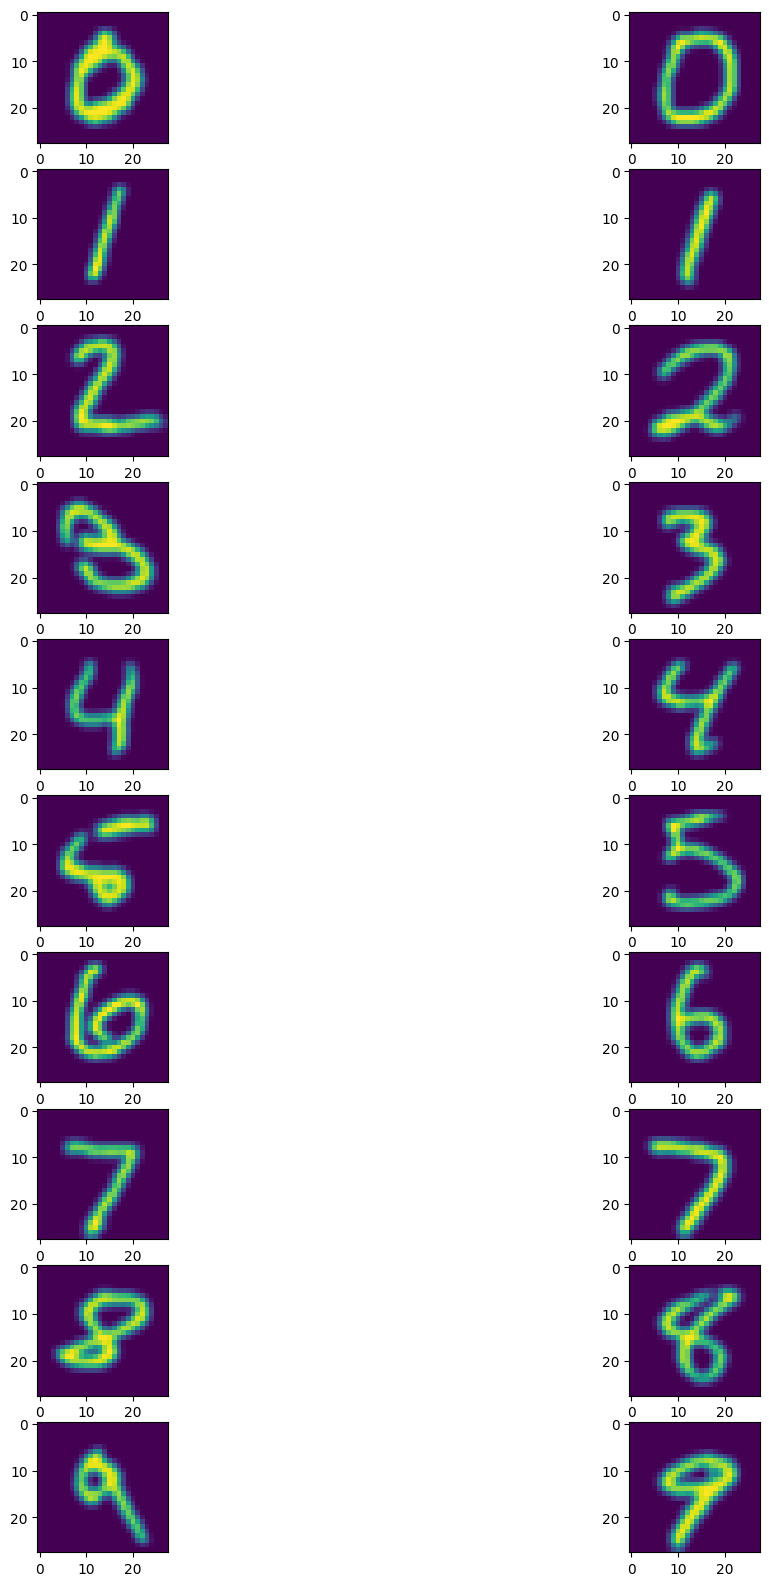

In [7]:
fig, axes = plt.subplots(10, examples_per_digit, figsize=(14, 20))
for i in range(10):
    for j in range(examples_per_digit):
        axes[i][j].imshow(digits[examples_per_digit * i + j])
        
plt.show()

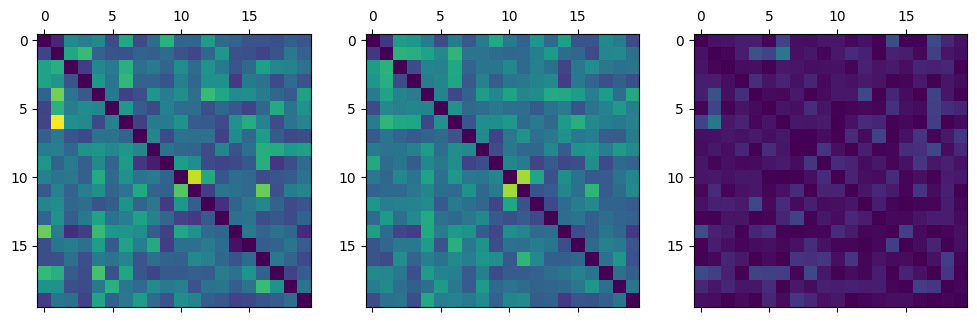

In [8]:
plot_distance_matrix(distance_matrix)